# Statistiche di valutazione del modello addestrato

In [11]:
from glob import glob
import os
import numpy as np

def load_logits_dir(save_dir='output/val_logits', prefix='val'):
    """Carica e concatena i file .npz prodotti dalla validazione.
    Preferisce i file merged per-rank, altrimenti usa gli shard per-batch.
    Ritorna: logits (N,C), labels (N,), preds (N,), paths (N,)
    """
    merged = sorted(glob(os.path.join(save_dir, f"{prefix}_rank*_merged.npz")))
    files = merged if len(merged) > 0 else sorted(glob(os.path.join(save_dir, f"{prefix}_rank*_*part*.npz")))
    if len(files) == 0:
        raise FileNotFoundError(f'No npz files found in {save_dir}')
    logits_list, labels_list, preds_list, paths_list = [], [], [], []
    for f in files:
        with np.load(f, allow_pickle=True) as d:
            logits_list.append(d['logits'])
            labels_list.append(d['labels'])
            preds_list.append(d['preds'])
            paths_list.append(d['paths'])
    logits = np.concatenate(logits_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    preds = np.concatenate(preds_list, axis=0)
    paths = np.concatenate(paths_list, axis=0)
    return logits, labels, preds, paths

logits, labels, preds, paths = load_logits_dir('output/val_logits', prefix='val')
logits.shape, labels.shape, preds.shape, paths.shape


((10, 2), (10,), (10,), (10,))

/tmp/ipykernel_222473/264790708.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', max(10, len(uniq)))


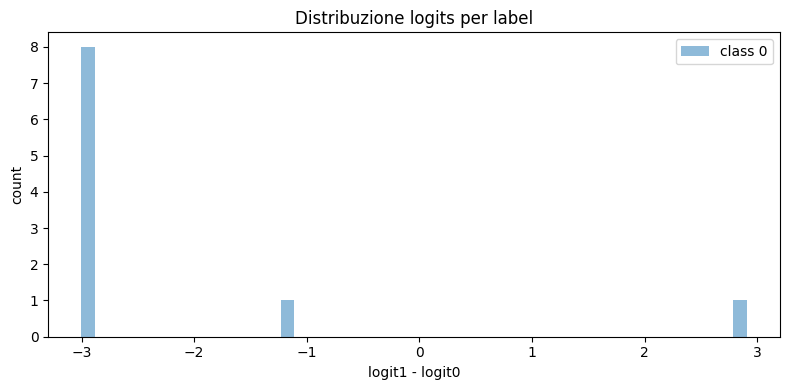

In [12]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.decomposition import PCA
    _HAS_SK = True
except Exception:
    _HAS_SK = False

def plot_logits_by_label(logits, labels, class_names=None, max_points=20000, alpha=0.5):
    logits = np.asarray(logits)
    labels = np.asarray(labels).astype(int)
    C = logits.shape[1]
    # Subsample per scatter denso
    if logits.shape[0] > max_points:
        rng = np.random.RandomState(0)
        idx = rng.choice(logits.shape[0], size=max_points, replace=False)
        X = logits[idx]
        y = labels[idx]
    else:
        X = logits
        y = labels
    uniq = np.unique(y)
    cmap = plt.cm.get_cmap('tab10', max(10, len(uniq)))
    if C == 2:
        # distribuzione del logit differenza (pos - neg)
        score = X[:, 1] - X[:, 0]
        plt.figure(figsize=(8, 4))
        for i, lab in enumerate(uniq):
            m = (y == lab)
            lbl = class_names[lab] if class_names is not None and lab < len(class_names) else f'class {lab}'
            plt.hist(score[m], bins=50, alpha=0.5, label=lbl, color=cmap(i))
        plt.xlabel('logit1 - logit0')
        plt.ylabel('count')
        plt.title('Distribuzione logits per label')
        plt.legend()
        plt.tight_layout()
    else:
        # PCA a 2D per scatter colorato per label
        if _HAS_SK:
            Z = PCA(n_components=2).fit_transform(X)
            xlabel, ylabel = 'PC1', 'PC2'
        else:
            Z = X[:, :2] if X.shape[1] >= 2 else np.pad(X, ((0,0),(0, 2-X.shape[1])), mode='constant')
            xlabel, ylabel = 'logit[0]', 'logit[1]'
        plt.figure(figsize=(6, 6))
        for i, lab in enumerate(uniq):
            m = (y == lab)
            lbl = class_names[lab] if class_names is not None and lab < len(class_names) else f'class {lab}'
            plt.scatter(Z[m, 0], Z[m, 1], s=10, alpha=alpha, label=lbl, color=cmap(i))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title('Logits (ridotti) per label')
        plt.legend()
        plt.tight_layout()

# esempio di utilizzo
plot_logits_by_label(logits, labels)


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from typing import List, Union
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [5]:
import os
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from arguments import prepare_finetuning_args, Args
from dataset import build_dataset
from torch.utils.data import DataLoader
import models
from timm.models import create_model

from engine_for_finetuning import validation_one_epoch_collect
from model_analysis import evaluate_binary_classifier, plot_metrics_over_time
from model_analysis import create_df_predictions, get_only_labels, confusion_counts_per_label
from dataset.build_dataset import (create_df_video_from_master_df, create_final_df_csv, make_relabeled_dataset, calc_avg_cld_idx, 
                                   create_and_save_tile_from_complete_df)

from dataset.data_manager import BuildDataset, DataManager
from dataset.dataset_labeling_study import aggiorna_label_distanza_temporale

output_dir = "../airmassRGB/supervised/" 
input_dir = "../fromgcloud"

### ricreo il dataset...
TODO -> rifattorizzare con le funzioni dentro build_dataset

In [ ]:
#make_relabeled_dataset(input_dir, output_dir, cloudy=True)
# mi serve soltanto la parte di test, quindi non giro tutto da capo ma prendo solo la creazione del df_video per il test, 
# e salvo le tile solo di quello



sup_data = BuildDataset(type='SUPERVISED', master_df_path="all_data_CL7_tracks_complete_fast.csv")
sup_data.load_master_df()
sup_data.calc_delta_time()

# sostotiuire con make_relabeled_master_df from build_dataset -> fatto in View_MED_val_preds.ipynb
new_label = aggiorna_label_distanza_temporale(sup_data .master_df, soglia=pd.Timedelta(hours=12), sub_lab=-1)
m = sup_data.master_df[new_label] == -1
df_mod = sup_data.master_df[~m].copy().drop(columns='label').rename(columns={new_label:'label'})
#

sup_data.make_df_video(new_master_df=df_mod, output_dir=None,  is_to_balance=True)


In [17]:
df_v = sup_data.df_video.copy()
#train e test
train_p = 0.7
len_p = int(train_p*df_v.shape[0])
df_video_train = df_v.sort_values('start_time').iloc[:len_p]
df_video_test = df_v.sort_values('start_time').iloc[len_p:]
print(f"Train e test lengths: {df_video_train.shape[0]}, {df_video_test.shape[0]}")

Train e test lengths: 2482, 1064


In [30]:
#df_video_test

In [ ]:
create_and_save_tile_from_complete_df(df_video_test, output_dir)

In [24]:
suffix = "_12h"
if True:
    #sup_data.df_video.path = output_dir + sup_data.df_video.path
    new_col_name = "avg_cloud_idx"
    print(f"Calcolando l'indice di nuvolosità...")
    df_video_test[new_col_name] = df_video_test.path.apply(calc_avg_cld_idx)
    mask_cloud = df_video_test.avg_cloud_idx > 0.2
    df_video_cloudy = df_video_test[mask_cloud]
    df_v = df_video_cloudy.copy()
    #df_v.path = df_v.path.str.split('/').str[-1]
    suffix += "_cloudy"

Calcolando l'indice di nuvolosità...


In [43]:
df_v.label.sum()/df_v.shape[0]

0.7780979827089337

In [ ]:
df_v.path = df_v.path.str.split('/').str[-1]
#df_v.path

In [27]:
# Salvo il csv 
df_dataset_csv_test = create_final_df_csv(df_v, output_dir)
df_dataset_csv_test.to_csv("./val_set.csv", index=False)

In [ ]:
# leggo il csv 
df_dataset_csv_test = pd.read_csv("./val_set.csv") #, parse_dates=['datetime'])

In [6]:
df_dataset_csv_test

,path,start,end,label
0,../airmassRGB/supervised/19-02-2020_1215_639_0,1,16,1
1,../airmassRGB/supervised/19-02-2020_1335_639_0,1,16,1
2,../airmassRGB/supervised/19-02-2020_1455_639_0,1,16,1
3,../airmassRGB/supervised/19-02-2020_1615_639_0,1,16,1
4,../airmassRGB/supervised/19-02-2020_1735_639_0,1,16,1
...,...,...,...,...
885,../airmassRGB/supervised/22-04-2020_1255_639_0,1,16,0
886,../airmassRGB/supervised/21-04-2020_1935_1065_0,1,16,0
887,../airmassRGB/supervised/21-04-2020_1935_0_196,1,16,0
888,../airmassRGB/supervised/20-04-2020_0055_426_0,1,16,0


In [8]:
df_dataset_csv_test_p =df_dataset_csv_test.copy()
df_dataset_csv_test_p.path = df_dataset_csv_test.path.str.split('/').str.get(-1)

# Creo dataloader e modello e eseguo inferenza

In [ ]:
### Codice di test su un piccolo dataset - più semplice rispetto a inference_classification.py

In [4]:
args = prepare_finetuning_args()

##### nel caso in cui voglio togliere video tiles di clear sky

In [ ]:
###### carico il dataset (applico filtro nuvolosità sui video di validation)
# Carico il csv di validation, calcolo avg_cloud_idx per ogni video usando
# la funzione `calc_avg_cld_idx` definita in dataset/build_dataset.py
try:
    df_val = pd.read_csv(args.val_path)
except Exception:
    # se non riesco a leggere il csv uso comunque il path originale
    df_val = None

if args.cloudy and df_val is not None and 'path' in df_val.columns:
    print('Calcolo indice di nuvolosità per i video di validation...')
    # Applichiamo direttamente la funzione ai percorsi
    df_val['avg_cloud_idx'] = df_val['path'].apply(lambda p: calc_avg_cld_idx(p))
    # soglia: manteniamo video con avg_cloud_idx <= 0.2 (come in build_dataset.filter_out_clear_sky)
    thresh = 0.2
    kept = df_val[df_val['avg_cloud_idx'] <= thresh].copy()
    print(f"Video totali: {len(df_val)} - dopo filtro nuvolosità (<= {thresh}): {len(kept)}")
    # salvo temporaneamente il csv filtrato e lo passo a DataManager
    filtered_csv = './val_filtered_for_prediction.csv'
    kept.to_csv(Path(args.csv_folder) / filtered_csv, index=False)
    val_csv_to_use = filtered_csv
else:
    val_csv_to_use = args.val_path

#### predizioni -> dataframe csv

In [6]:
args.test_path = "val_quick_test.csv"

test_m = DataManager(is_train=False, args=args, type_t='supervised', world_size=1, rank=0)  # , specify_data_path=val_csv_to_use)
test_m.create_classif_dataloader(args)

Getting dataset...
DATASET length: 10
Creo il DistributedSampler con world_size 1 e rank 0
Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7f9c5243c910>
Batch_size local: 1


In [7]:
all_paths, all_preds, all_labels = get_only_labels(test_m.data_loader)
print(len(all_paths), len(all_preds), len(all_labels))

10 10 10


In [8]:
# voglio prendere le predizioni
#get_prediction = True
args.device = 'cpu'
args.load_for_test_mode = True
#args.init_ckpt = './output/checkpoint-best-12h-cloudy.pth'
args.init_ckpt = './output/checkpoint-best-CL10.pth'

# istanzia l'oggetto del modello 
print(f"Creating model: {args.model} (nb_classes={args.nb_classes})")
model = create_model(
    args.model,
    num_classes=args.nb_classes,
    drop_rate=0.0,
    drop_path_rate=args.drop_path,
    #attn_drop_rate=0.0,
    drop_block_rate=None,
    **args.__dict__
)

model.to(args.device)
model.eval()

Creating model: vit_giant_patch14_224 (nb_classes=2)


Caricamento del checkpoint da: ./output/checkpoint-best-CL10.pth
Caricato state_dict con chiave: model
Checkpoint caricato con successo!


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 1408, kernel_size=(2, 14, 14), stride=(2, 14, 14))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1408, out_features=4224, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1408, out_features=1408, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1408, out_features=6144, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=6144, out_features=1408, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
  

In [9]:
torch.cuda.empty_cache()

# calcolo e prendo le predizioni
val_stats, all_paths, all_preds, all_labels = validation_one_epoch_collect(test_m.data_loader, model, args.device)
print(f"val bal_acc: {val_stats['bal_acc']:.2f}% ")

#all_paths, all_preds, all_labels = get_path_pred_label(model, test_m.data_loader)
#y_true = np.array(all_labels)
#y_pred  = np.array(all_preds)
df_predictions = create_df_predictions(all_paths, all_preds, all_labels)
#df_predictions.shape[0]

/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Val:  [ 0/10]  eta: 0:05:06  loss: 0.0490 (0.0490)  acc: 1.0000 (1.0000)  bal_acc: 0.5000 (0.5000)  pod: 0.0000 (0.0000)  far: 0.0000 (0.0000)  time: 30.6979 (30.6979 -- 30.6979)  data: 0.0679 (0.0679 -- 0.0679)
Val:  [ 9/10]  eta: 0:00:29  loss: 0.0498 (0.3631)  acc: 1.0000 (0.9000)  bal_acc: 0.5000 (0.4500)  pod: 0.0000 (0.0000)  far: 0.0000 (0.1000)  time: 29.9711 (29.1355 -- 31.3557)  data: 0.0078 (0.0001 -- 0.0679)
Val: Total time: 0:04:59 (29.9713 s / it)
* Balanced Acc@1 0.450  loss 0.363
val bal_acc: 0.45% 


In [10]:
from engine_for_finetuning import validation_one_epoch_collect_logits
# Flag di fallback: se non c'è GPU usa CPU
ALLOW_CPU_FALLBACK = True
if torch.cuda.is_available():
    dev = torch.device('cuda')
else:
    if not ALLOW_CPU_FALLBACK:
        raise RuntimeError('CUDA non disponibile; abilita ALLOW_CPU_FALLBACK per usare CPU')
    print('CUDA non disponibile: uso CPU per validazione/logits.')
    dev = torch.device('cpu')
# Porta il modello sul device scelto (se definito)
try:
    model = model.to(dev)
except Exception:
    pass
save_dir = 'output/val_logits'
stats = validation_one_epoch_collect_logits(
    test_m.data_loader,
    model,
    dev,
    save_dir=save_dir,
    prefix='val',
)
print(f"Saved logits shards/merge under: {save_dir}")
print(f"Balanced Acc: {stats['bal_acc']:.3f} | Acc: {stats['acc']:.3f}")


CUDA non disponibile: uso CPU per validazione/logits.
Val:  [ 0/10]  eta: 0:04:49  loss: 0.0490 (0.0490)  acc: 1.0000 (1.0000)  bal_acc: 0.5000 (0.5000)  pod: 0.0000 (0.0000)  far: 0.0000 (0.0000)  time: 28.9282 (28.9282 -- 28.9282)  data: 0.0668 (0.0668 -- 0.0668)
Val:  [ 9/10]  eta: 0:00:28  loss: 0.0498 (0.3631)  acc: 1.0000 (0.9000)  bal_acc: 0.5000 (0.4500)  pod: 0.0000 (0.0000)  far: 0.0000 (0.1000)  time: 28.6354 (28.1590 -- 29.7996)  data: 0.0070 (0.0001 -- 0.0668)
Val: Total time: 0:04:46 (28.6356 s / it)
* Balanced Acc@1 0.450  loss 0.363
Saved merged (rank=0) to: output/val_logits/val_rank0_merged.npz
Saved logits shards/merge under: output/val_logits
Balanced Acc: 0.450 | Acc: 0.900


In [7]:
df_predictions = pd.read_csv('output/inference_predictions.csv')

In [22]:
df_predictions

,path,predictions,labels
0,01-03-2016_0000_0_0,0,0
1,01-03-2016_0000_0_196,0,0
2,01-03-2016_0000_1065_0,0,0
3,01-03-2016_0000_1065_196,0,0
4,01-03-2016_0000_213_0,0,0
5,01-03-2016_0000_213_196,0,0
6,01-03-2016_0000_426_0,0,0
7,01-03-2016_0000_426_196,1,0
8,01-03-2016_0000_639_0,0,0
9,01-03-2016_0000_639_196,0,0


In [11]:
#df_dataset_csv_test_p.merge(df_predictions, on='path')

In [ ]:
(y_true == y_pred).sum()#/890

0.6730337078651686

# Modifica delle label dal Master df per verifica del periodo di formazione e fine del ciclone


In [ ]:
from dataset.dataset_labeling_study import aggiorna_label_distanza_temporale, create_tile_videos_relabeling, create_df_video_from_master_df_relabeling
from dataset.build_dataset import get_gruppi_date, create_tile_videos, group_df_by_offsets

In [70]:
step = pd.Timedelta(minutes=60)
for i in range(1, 72):
    t = i * step
    print(t)
    aggiorna_label_distanza_temporale(df_data, soglia=t)

0 days 01:00:00
Colonna label_01_00 aggiunta
0 days 02:00:00
Colonna label_02_00 aggiunta
0 days 03:00:00
Colonna label_03_00 aggiunta
0 days 04:00:00
Colonna label_04_00 aggiunta
0 days 05:00:00
Colonna label_05_00 aggiunta
0 days 06:00:00
Colonna label_06_00 aggiunta
0 days 07:00:00
Colonna label_07_00 aggiunta
0 days 08:00:00
Colonna label_08_00 aggiunta
0 days 09:00:00
Colonna label_09_00 aggiunta
0 days 10:00:00
Colonna label_10_00 aggiunta
0 days 11:00:00
Colonna label_11_00 aggiunta
0 days 12:00:00
Colonna label_12_00 aggiunta
0 days 13:00:00
Colonna label_13_00 aggiunta
0 days 14:00:00
Colonna label_14_00 aggiunta
0 days 15:00:00
Colonna label_15_00 aggiunta
0 days 16:00:00
Colonna label_16_00 aggiunta
0 days 17:00:00
Colonna label_17_00 aggiunta
0 days 18:00:00
Colonna label_18_00 aggiunta
0 days 19:00:00
Colonna label_19_00 aggiunta
0 days 20:00:00
Colonna label_20_00 aggiunta
0 days 21:00:00
Colonna label_21_00 aggiunta
0 days 22:00:00
Colonna label_22_00 aggiunta
0 days 23:

In [ ]:
#tile_mask = (df_data[['tile_offset_x','tile_offset_y']] == (852, 196)).all(axis=1)

In [71]:
#[['label', 'datetime', 'delta_time', 'label_00_20', 'label_03_00']]
# Seleziona tutte le colonne il cui nome inizia con 'label'
label_cols = [col for col in df_data.columns if col.startswith('label')]
print(f"Nuove colonne create: {label_cols}")

# Crea un nuovo DataFrame solo con quelle colonne
#df_label = df_data.loc[tile_mask, label_cols+ ['path', 'tile_offset_x','tile_offset_y', 'datetime']]
df_label = df_data[label_cols+ ['path', 'tile_offset_x','tile_offset_y', 'datetime']]
df_label


Nuove colonne create: ['label', 'label_00_40', 'label_01_20', 'label_02_00', 'label_02_40', 'label_03_20', 'label_04_00', 'label_04_40', 'label_05_20', 'label_06_00', 'label_01_00', 'label_03_00', 'label_05_00', 'label_07_00', 'label_08_00', 'label_09_00', 'label_10_00', 'label_11_00', 'label_12_00', 'label_13_00', 'label_14_00', 'label_15_00', 'label_16_00', 'label_17_00', 'label_18_00', 'label_19_00', 'label_20_00', 'label_21_00', 'label_22_00', 'label_23_00', 'label_24_00', 'label_25_00', 'label_26_00', 'label_27_00', 'label_28_00', 'label_29_00', 'label_30_00', 'label_31_00', 'label_32_00', 'label_33_00', 'label_34_00', 'label_35_00', 'label_36_00', 'label_37_00', 'label_38_00', 'label_39_00', 'label_40_00', 'label_41_00', 'label_42_00', 'label_43_00', 'label_44_00', 'label_45_00', 'label_46_00', 'label_47_00', 'label_48_00', 'label_49_00', 'label_50_00', 'label_51_00', 'label_52_00', 'label_53_00', 'label_54_00', 'label_55_00', 'label_56_00', 'label_57_00', 'label_58_00', 'label_5

,label,label_00_40,label_01_20,label_02_00,label_02_40,label_03_20,label_04_00,label_04_40,label_05_20,label_06_00,...,label_66_00,label_67_00,label_68_00,label_69_00,label_70_00,label_71_00,path,tile_offset_x,tile_offset_y,datetime
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20200101_1200.png,0,0,2020-01-01 12:00:00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20200101_1200.png,213,0,2020-01-01 12:00:00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20200101_1200.png,426,0,2020-01-01 12:00:00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20200101_1200.png,639,0,2020-01-01 12:00:00
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20200101_1200.png,852,0,2020-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20201228_0100.png,213,196,2020-12-28 01:00:00
279368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20201228_0100.png,426,196,2020-12-28 01:00:00
279369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20201228_0100.png,639,196,2020-12-28 01:00:00
279370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,../fromgcloud/airmass_rgb_20201228_0100.png,852,196,2020-12-28 01:00:00


In [124]:
df_videos_many_labels

,video_id,tile_offset_x,tile_offset_y,path,label,start_time,end_time,orig_paths,label_00_40,label_01_20,...,label_62_00,label_63_00,label_64_00,label_65_00,label_66_00,label_67_00,label_68_00,label_69_00,label_70_00,label_71_00
0,0,0,0,01-01-2020_1315_0_0,0,2020-01-01 12:00:00,2020-01-01 13:15:00,"[../fromgcloud/airmass_rgb_20200101_1200.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,01-01-2020_1435_0_0,0,2020-01-01 13:20:00,2020-01-01 14:35:00,"[../fromgcloud/airmass_rgb_20200101_1320.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,01-01-2020_1555_0_0,0,2020-01-01 14:40:00,2020-01-01 15:55:00,"[../fromgcloud/airmass_rgb_20200101_1440.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,01-01-2020_1715_0_0,0,2020-01-01 16:00:00,2020-01-01 17:15:00,"[../fromgcloud/airmass_rgb_20200101_1600.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,01-01-2020_1835_0_0,0,2020-01-01 17:20:00,2020-01-01 18:35:00,"[../fromgcloud/airmass_rgb_20200101_1720.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,787,1065,196,27-12-2020_1935_1065_196,0,2020-12-27 18:20:00,2020-12-27 19:35:00,"[../fromgcloud/airmass_rgb_20201227_1820.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
788,788,1065,196,27-12-2020_2055_1065_196,0,2020-12-27 19:40:00,2020-12-27 20:55:00,"[../fromgcloud/airmass_rgb_20201227_1940.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
789,789,1065,196,27-12-2020_2215_1065_196,0,2020-12-27 21:00:00,2020-12-27 22:15:00,"[../fromgcloud/airmass_rgb_20201227_2100.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
790,790,1065,196,27-12-2020_2335_1065_196,0,2020-12-27 22:20:00,2020-12-27 23:35:00,"[../fromgcloud/airmass_rgb_20201227_2220.png, ...",0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_videos_many_labels = create_df_video_from_master_df_relabeling(df_label)

Righe del df_video: 1044
Righe del df_video: 840
Righe del df_video: 468
Righe del df_video: 252
Righe del df_video: 468
Righe del df_video: 792
Righe del df_video: 708
Righe del df_video: 504
Righe del df_video: 708
Righe del df_video: 120
Righe del df_video: 1128
Righe del df_video: 48
Righe del df_video: 756
Righe del df_video: 864
Righe del df_video: 144
Righe del df_video: 60
Righe del df_video: 1464
Righe del df_video: 420
Righe del df_video: 612
Righe del df_video: 852
Righe del df_video: 1056
Righe del df_video: 1512
Righe del df_video: 648
Righe del df_video: 1080
Righe del df_video: 792


In [ ]:
#df_videos_many_labels[label_cols+['path']]
df_videos_many_labels.columns

,label,label_00_40,label_01_20,label_02_00,label_02_40,label_03_20,label_04_00,label_04_40,label_05_20,label_06_00,...,label_63_00,label_64_00,label_65_00,label_66_00,label_67_00,label_68_00,label_69_00,label_70_00,label_71_00,path
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,01-01-2020_1315_0_0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,01-01-2020_1435_0_0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,01-01-2020_1555_0_0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,01-01-2020_1715_0_0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,01-01-2020_1835_0_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27-12-2020_1935_1065_196
788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27-12-2020_2055_1065_196
789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27-12-2020_2215_1065_196
790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27-12-2020_2335_1065_196


In [74]:
df_predictions

,path,predictions,labels
0,22-02-2020_1215_1065_196,0,1
1,20-03-2020_1555_213_196,1,1
2,20-02-2020_2015_426_196,0,0
3,21-03-2020_0915_426_196,1,1
4,17-03-2020_0035_213_196,1,1
...,...,...,...
885,20-03-2020_1835_426_196,0,1
886,21-02-2020_0135_852_196,1,1
887,17-03-2020_0315_426_196,0,0
888,14-04-2020_1815_639_196,0,1


In [75]:
df_result = df_videos_many_labels[label_cols+['path']].merge(df_predictions) #, on='path')
#df_videos.merge(val_dataset, on='path')

In [76]:
df_result_sorted = df_result.sort_values('path').reset_index(drop=True)
df_pred_sorted = df_predictions.sort_values('path').reset_index(drop=True)

In [77]:
print(all(df_result_sorted['label'] == df_pred_sorted['labels']))  # Ora può funzionare
print(all(df_result_sorted['predictions'] == df_pred_sorted['predictions']))

True
True


In [78]:
all(df_result.labels == df_result.label)

True

In [79]:
# allora posso rimuovere la colonna labels
df_result.drop(columns='labels', inplace=True)

In [ ]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)
df_result[df_result.path.str.contains('19-02-2020_')]

,label,label_00_40,label_01_20,label_02_00,label_02_40,label_03_20,label_04_00,label_04_40,label_05_20,label_06_00,...,label_64_00,label_65_00,label_66_00,label_67_00,label_68_00,label_69_00,label_70_00,label_71_00,path,predictions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,19-02-2020_2255_0_0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20-02-2020_0935_0_0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20-02-2020_1335_0_0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20-02-2020_1855_0_0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22-02-2020_0255_0_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21-04-2020_0855_1065_196,1
886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21-04-2020_1935_1065_196,1
887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21-04-2020_2335_1065_196,0
888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22-04-2020_1815_1065_196,0


In [38]:
y_true = np.array(all_labels)
y_pred  = np.array(all_preds)
#np.save("y_true.npy",y_true)
#np.save("y_pred.npy",y_pred)


In [15]:
y_true = np.load("y_true.npy")
y_pred = np.load("y_pred.npy")

# Calcola le metriche

### metriche singole

In [12]:
from model_analysis import evaluate_binary_classifier, plot_confusion_and_results

In [ ]:
df_predictions = pd.read_csv('output/inference_predictions_balanced.csv')

=== Confusion Matrix ===
[[158  19]
 [ 13 178]]

=== Metriche ===
accuracy               0.913043
balanced_accuracy      0.912296
recall                 0.931937
true_negatives       158.000000
false_positives       19.000000
false_negatives       13.000000
true_positives       178.000000
far                    0.096447
csi                    0.847619
hss                    0.825618
Name: metrics, dtype: float64


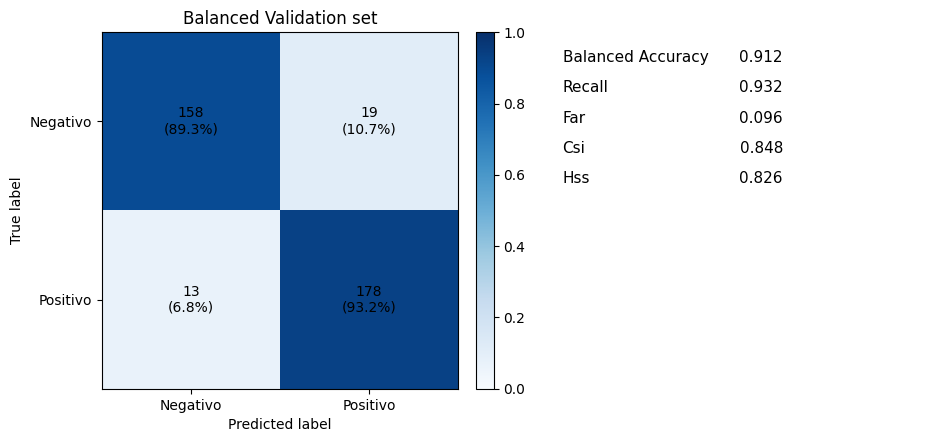

In [14]:
results = evaluate_binary_classifier(df_predictions.labels, df_predictions.predictions) #[:,0])
print("\n=== Metriche ===")
print(results)

plot_confusion_and_results(results, labels=("Negativo","Positivo"), title="Balanced Validation set", savepath='output/conf_matrix.png', normalize=True)

=== Confusion Matrix ===
[[1795  404]
 [   6  195]]

=== Metriche ===
accuracy                0.829167
balanced_accuracy       0.893215
recall                  0.970149
true_negatives       1795.000000
false_positives       404.000000
false_negatives         6.000000
true_positives        195.000000
far                     0.674457
csi                     0.322314
hss                     0.414007
Name: metrics, dtype: float64


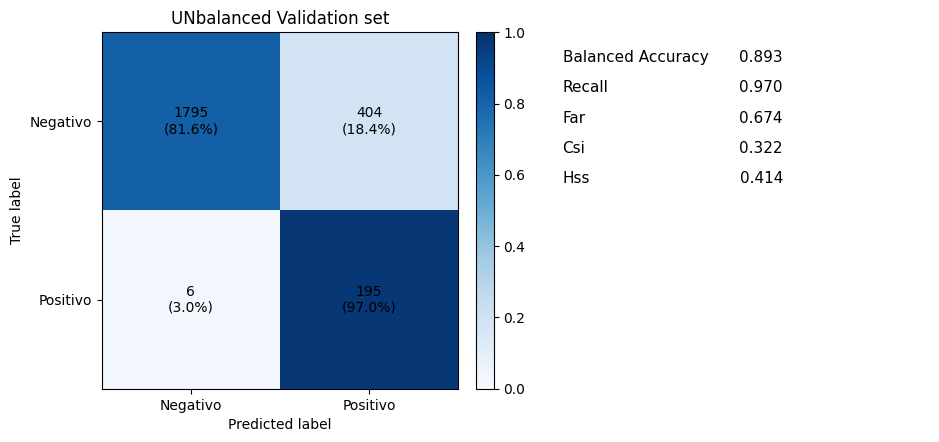

In [15]:
df_predictions = pd.read_csv('output/inference_predictions_UNbalanced.csv')
results = evaluate_binary_classifier(df_predictions.labels, df_predictions.predictions) #[:,0])
print("\n=== Metriche ===")
print(results)

plot_confusion_and_results(results, labels=("Negativo","Positivo"), title="UNbalanced Validation set", savepath='output/conf_matrix_UNb.png', normalize=True)

In [12]:
results = evaluate_binary_classifier(df_predictions.labels, df_predictions.predictions) #[:,0])
print("\n=== Metriche ===")
print(results)

=== Confusion Matrix ===
[[63 11]
 [ 7 67]]
True Positive: 67
True Negative: 63
False Positive: 11
False Negative: 7

=== Classification Report ===
              precision    recall  f1-score   support

         neg       0.90      0.85      0.88        74
         pos       0.86      0.91      0.88        74

    accuracy                           0.88       148
   macro avg       0.88      0.88      0.88       148
weighted avg       0.88      0.88      0.88       148


=== Metriche ===
accuracy              0.878378
balanced_accuracy     0.878378
precision             0.858974
recall                0.905405
f1                    0.881579
matthews_corrcoef     0.757865
cohen_kappa           0.756757
true_negatives       63.000000
false_positives      11.000000
false_negatives       7.000000
true_positives       67.000000
Name: metrics, dtype: float64


In [51]:
results = evaluate_binary_classifier(df_result.label, df_result.predictions) #[:,0])
print("\n=== Metriche ===")
print(results)  # risulta uguale quindi ok!

=== Confusion Matrix ===
[[332 113]
 [178 267]]
True Positive: 267
True Negative: 332
False Positive: 113
False Negative: 178

=== Classification Report ===
              precision    recall  f1-score   support

         neg       0.65      0.75      0.70       445
         pos       0.70      0.60      0.65       445

    accuracy                           0.67       890
   macro avg       0.68      0.67      0.67       890
weighted avg       0.68      0.67      0.67       890


=== Metriche ===
accuracy               0.673034
balanced_accuracy      0.673034
precision              0.702632
recall                 0.600000
f1                     0.647273
matthews_corrcoef      0.349819
cohen_kappa            0.346067
true_negatives       332.000000
false_positives      113.000000
false_negatives      178.000000
true_positives       267.000000
Name: metrics, dtype: float64


### metriche al variare della label

In [104]:
label_cols[:43]

['label',
 'label_00_40',
 'label_01_20',
 'label_02_00',
 'label_02_40',
 'label_03_20',
 'label_04_00',
 'label_04_40',
 'label_05_20',
 'label_06_00',
 'label_01_00',
 'label_03_00',
 'label_05_00',
 'label_07_00',
 'label_08_00',
 'label_09_00',
 'label_10_00',
 'label_11_00',
 'label_12_00',
 'label_13_00',
 'label_14_00',
 'label_15_00',
 'label_16_00',
 'label_17_00',
 'label_18_00',
 'label_19_00',
 'label_20_00',
 'label_21_00',
 'label_22_00',
 'label_23_00',
 'label_24_00',
 'label_25_00',
 'label_26_00',
 'label_27_00',
 'label_28_00',
 'label_29_00',
 'label_30_00',
 'label_31_00',
 'label_32_00',
 'label_33_00',
 'label_34_00',
 'label_35_00',
 'label_36_00']

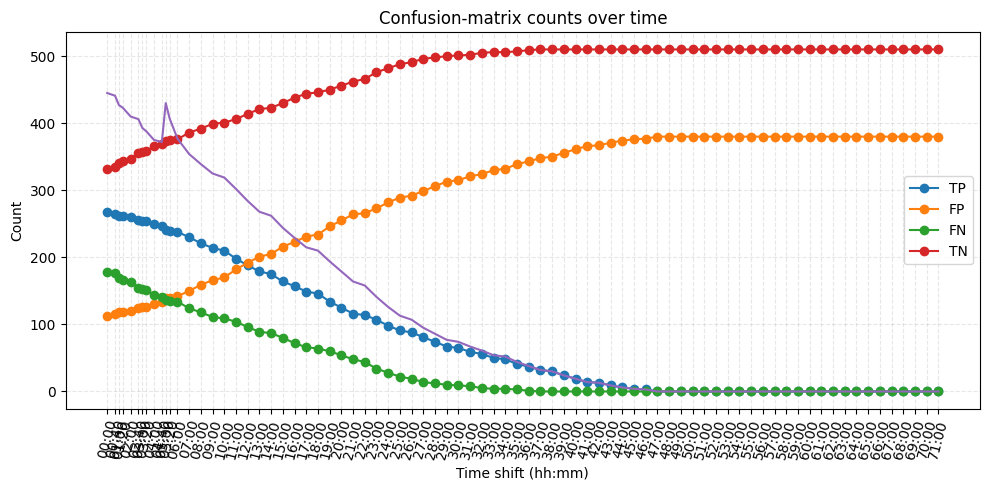

In [106]:
conf_df = confusion_counts_per_label(
    df_result,
    pred_col='predictions',
    label_cols=label_cols
)

# 3) Plot (cambia metrics se vuoi mostrare solo alcune colonne)
plot_metrics_over_time(
    conf_df,
    metrics=('tp', 'fp', 'fn', 'tn'),   # oppure ('tp','fp') … a tua scelta
    sum_labels=df_result[label_cols].sum()
)

In [107]:
df_result.predictions.sum()/df_result.shape[0]

0.42696629213483145

In [ ]:
df_result.label.sum()/df_result.shape[0]

0.5

In [118]:
df_result.shape[0]

890

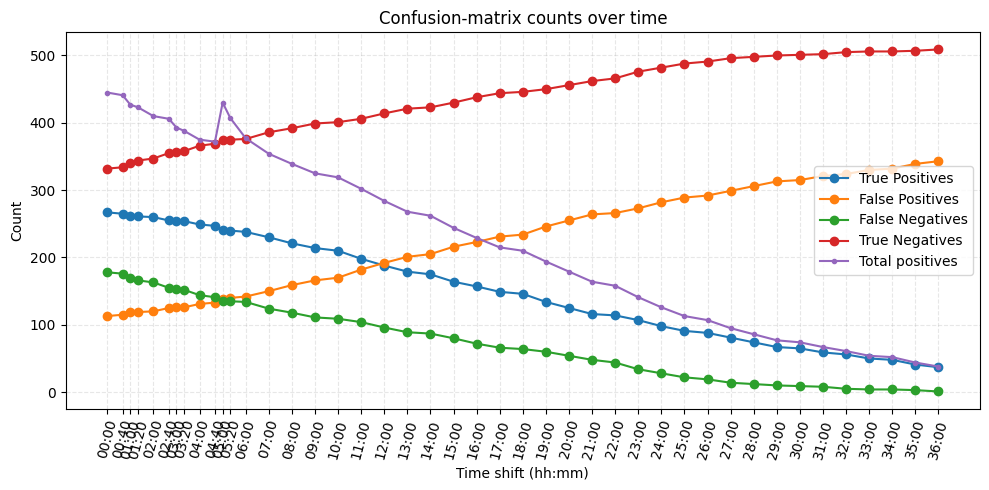

In [110]:
label_cols_ridotte = label_cols[:43]
df_r = df_result[label_cols_ridotte + ['predictions']]
conf_df = confusion_counts_per_label(
    df_r,
    pred_col='predictions',
    label_cols=label_cols_ridotte
)

# 3) Plot (cambia metrics se vuoi mostrare solo alcune colonne)
plot_metrics_over_time(
    conf_df,
    metrics=('tp', 'fp', 'fn', 'tn'),   # oppure ('tp','fp') … a tua scelta
    sum_labels=df_r[label_cols_ridotte].sum()
)